# 3. Ambient noise cross-correlation

<img width=150px src="https://www.ipgp.fr/sites/default/files/ipgp_up_verticaux_rvb.png" />

## Preamble

This Jupyter notebook shows how to __use continuous seismograms to estimate the Green's function__, as part of the _Scientific Computing for Geophysical Problems_ class. This notebook is inspired from the available online notebook [_Ambient Seismic Noise Analysis_](https://krischer.github.io/seismo_live_build/html/Ambient%20Seismic%20Noise/NoiseCorrelation.html) created by Celine Hadziioannou and Ashim Rijal. The goal of this notebook is to reproduce the Figure 1 from the paper [High-Resolution Surface-Wave Tomography from Ambient Seismic Noise, Nikolai M. Shapiro, et al. Science 307, 1615 (2005); DOI: 10.1126/science.1108339](https://www.science.org/doi/10.1126/science.1108339).

![](https://www.science.org/cms/10.1126/science.1108339/asset/287ef0b7-5c19-40f9-ab5d-3cb6aac92cfb/assets/graphic/307_1615_f1.jpeg)

## Requirements

This notebook relies on the four following Python libraries; please ensure that the virtual Python environment you are using includes them correctly:
- [ObsPy](https://github.com/obspy/obspy/wiki), an open-source project that provides a Python framework for processing seismological data. It provides parsers for standard file formats, clients to access data centers, and signal processing routines that allow the manipulation of seismological time series.
- [NumPy](https://numpy.org), an open-source project aiming to enable numerical computing with Python.
- [SciPy](https://numpy.org), fundamental algorithms for scientific computing in Python.
- [Matplotlib](https://matplotlib.org), a comprehensive library for creating static, animated, and interactive visualizations in Python.

If unavailable on your machine, the following steps will guide you towards correctly installing the packages mentioned above. [Anaconda](https://www.anaconda.com) is a Python package manager that allows you to install Python libraries easily and is available from the virtual machine. If you wish to install it on your machine locally, please follow the instructions at https://www.anaconda.com. The following steps create a new environment named `scientific_computing` and install the latest version of Python 3.10 with ObsPy and Matplotlib. Note that the library NumPy is automatically installed with ObsPy. This will allow you to run this notebook properly.

In [2]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from scipy import signal

from lab_3_module import *

## Data download

Firstly, we need to download the data from the seismic station MLAC and PHL as presented in the above figure. Using the previous notebooks, find out the network name of these two stations, and complete the cell below to download the data.

In [3]:
STREAM_DURATION_DAYS = 4
START_DATE = "2004-10-20T00:00:00"
NETWORK_NAME = "CI"

# Connect to the IRIS database
client = Client("IRIS")

# Start and end times
starttime = obspy.UTCDateTime(START_DATE)
endtime = starttime + (STREAM_DURATION_DAYS * 86400)

# Collect traces into a single stream
stream = client.get_waveforms(
    network=NETWORK_NAME,
    station="MLAC",
    location="*",
    channel="LHZ",
    starttime=starttime,
    endtime=endtime,
)

stream += client.get_waveforms(
    network=NETWORK_NAME,
    station="PHL",
    location="*",
    channel="LHZ",
    starttime=starttime,
    endtime=endtime,
)

# Show stream
stream

2 Trace(s) in Stream:
CI.MLAC..LHZ | 2004-10-20T00:00:00.230800Z - 2004-10-23T23:59:59.230800Z | 1.0 Hz, 345600 samples
CI.PHL..LHZ  | 2004-10-20T00:00:00.000000Z - 2004-10-24T00:00:00.000000Z | 1.0 Hz, 345601 samples

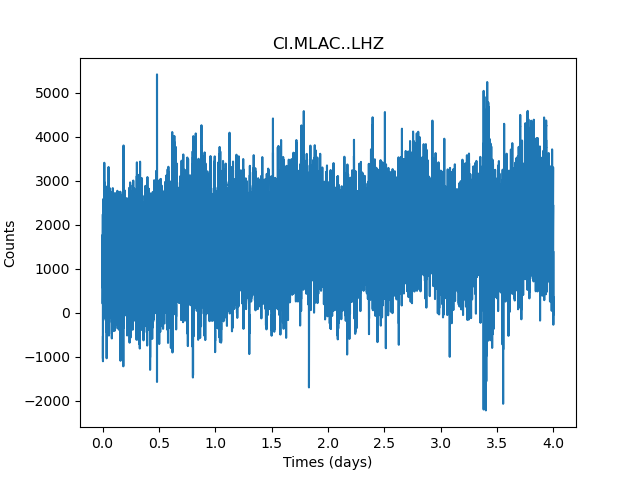

In [4]:
trace = stream[0]
times = trace.times()
times /= 24 * 3600
waveform = trace.data

plt.figure(1)
plt.clf()
plt.plot(times, waveform)
plt.xlabel("Times (days)")
plt.ylabel("Counts")
plt.title(trace.id)
plt.show()

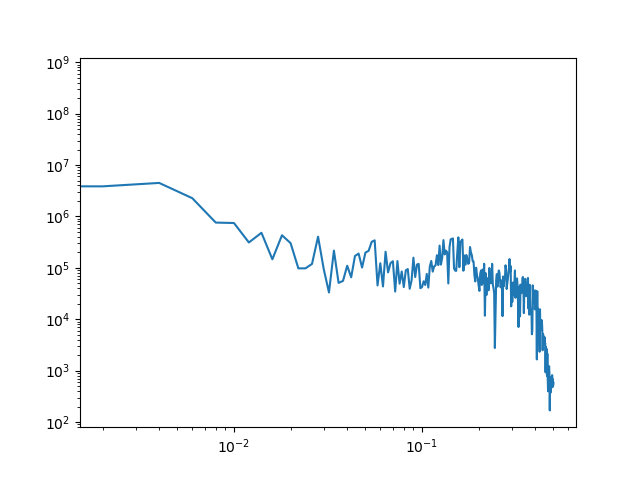

In [5]:
window_size = 500
n_windows = len(waveform) // window_size
spectrum = np.zeros(window_size // 2 + 1, dtype="complex")
waveforms = waveform[:n_windows * window_size].reshape(n_windows, window_size)
for i in range(n_windows):
    spectrum += np.fft.rfft(waveforms[i])
frequencies = np.fft.rfftfreq(window_size, trace.stats.delta)

plt.figure(2)
plt.clf()
plt.loglog(frequencies, np.abs(spectrum))
plt.show()

## First pre-processing

We first narrow the focus on detrending, tapering and filtering the data in a particular frequency band of interest. __Show the two streams and compare their temporal behaviour. Also inspect their spectral properties with a Fourier transform.__

In [7]:
stream_processed = stream.copy()
stream_processed.detrend("linear")
stream_processed.taper(max_percentage=0.05, type="cosine")
stream_processed.filter("bandpass", freqmin=0.1, freqmax=0.2, zerophase=True)

2 Trace(s) in Stream:
CI.MLAC..LHZ | 2004-10-20T00:00:00.230800Z - 2004-10-23T23:59:59.230800Z | 1.0 Hz, 345600 samples
CI.PHL..LHZ  | 2004-10-20T00:00:00.000000Z - 2004-10-24T00:00:00.000000Z | 1.0 Hz, 345601 samples

## Second pre-processing

Here we apply the noise pre-processing steps as proposed by Bense et al. (2007). We first normalize the continuous stream in time, then in the spectral domain in order to balance the source distribution and stationarize it in time. __Show the two streams and compare their temporal behaviour. Also inspect their spectral properties with a Fourier transform. What are the different normalization strategies and how do they impact the normalized signal?__

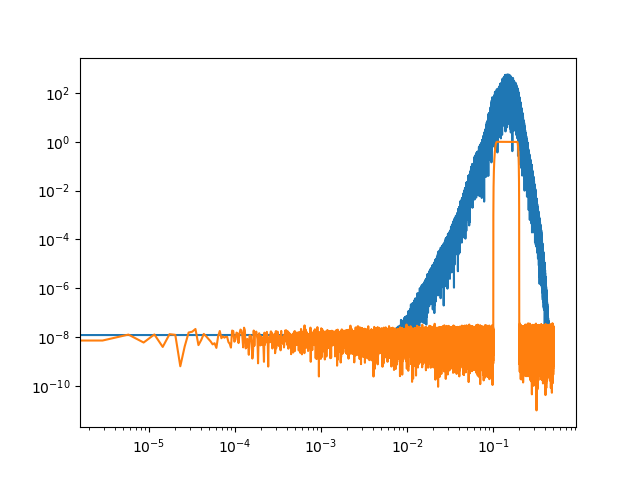

In [18]:
stream_noise = stream_processed.copy()

for trace in stream_noise:
    trace = normalize(trace, norm_method="1bit")
    trace = whiten(trace, 0.1, 0.2)


waveform_filtered = stream_processed[0].data
spectrum_filtered = np.fft.rfft(waveform_filtered)
waveform_processed = stream_noise[0].data
spectrum_processed = np.fft.rfft(waveform_processed)
frequencies = np.fft.rfftfreq(len(waveform_filtered))
times = stream[0].times()

plt.figure(3)
plt.clf()
plt.loglog(frequencies, np.abs(spectrum_filtered), rasterized=True)
plt.loglog(frequencies, np.abs(spectrum_processed), rasterized=True)
plt.show()


## Cross-correlation

Here we cross-correlate the two traces into small windows and stack the obtained cross-correlations in every window. __Calculate the stacked cross-correlation from the different windows (average). Compare all the cross-correlations and the stacked cross-correlation. Where is the signal of interest? Why is this function assymetrical?__

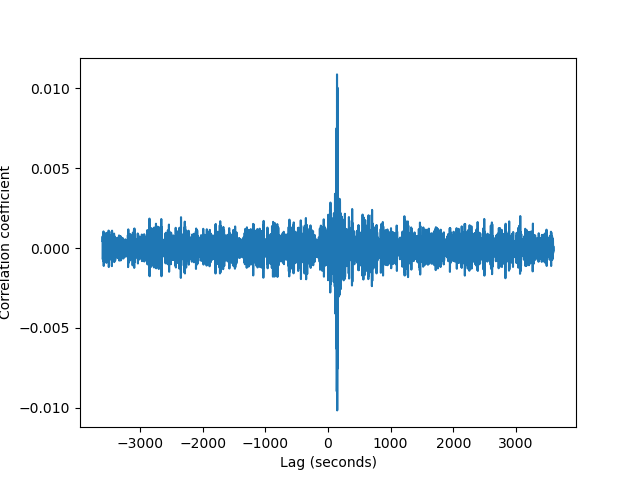

In [24]:
xcorr, lags = correlateNoise(stream_noise, ['MLAC','PHL'], 7200)

plt.figure(4)
plt.clf()
plt.plot(lags, xcorr.sum(axis=0))
plt.xlabel("Lag (seconds)")
plt.ylabel("Correlation coefficient")
plt.show()


## Comparison with an earthquake signal

In 1998, a M5.1 event occurred next to station MLAC, and was recorded by the seismic station PHL. The goal of the next cell is to convince ourselves that the cross-correlation efficiently converged to the Green's function between MLAC and PHL by comparing it to the earthquake record. This assumes that the earthquake is small enough to consider its record as the impulse response. 

In [25]:
stream_earthquake = obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/event.CI.PHL.LHZ.1998.196.1998.196.mseed')


# Apply a similar processing to allow for comparison
stream_earthquake.detrend('linear')
stream_earthquake.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
for tr in stream_earthquake:
    tr = whiten(tr, 0.1, 0.2)

stream_earthquake

1 Trace(s) in Stream:
CI.PHL..LHZ | 1998-07-15T03:53:20.973514Z - 1998-07-15T05:53:20.973514Z | 1.0 Hz, 7201 samples

## Final comparison

On a same plot, display the cross-correlation function between MLAC and PHL, and the event recorded at PHL. Please, comment.

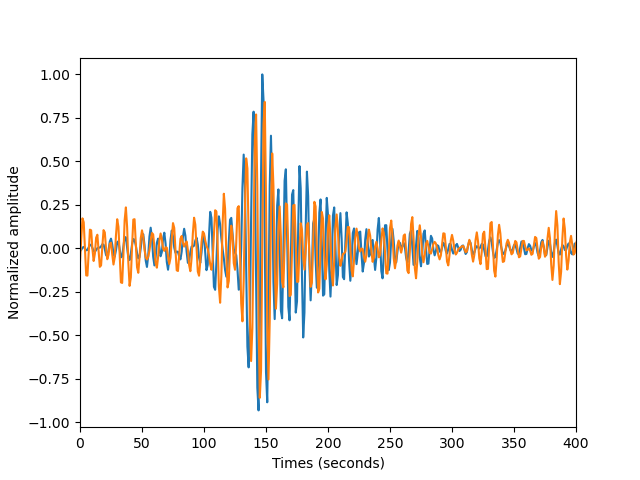

In [36]:
DURATION_SEC = 400

EVENT_TIME = obspy.UTCDateTime(1998, 7, 15, 4, 53, 21, 0)
stream_earthquake[0].trim(EVENT_TIME, EVENT_TIME + DURATION_SEC)

# Plot here
times_noise = stream_noise[0].times()
times_earthquake = stream_earthquake[0].times()
waveform_earthquake = stream_earthquake[0].data
waveform_earthquake /= np.abs(waveform_earthquake).max()

waveform_cross_correlation = xcorr.sum(axis=0)
waveform_cross_correlation /= np.abs(waveform_cross_correlation).max()

plt.figure(5)
plt.clf()
plt.plot(times_earthquake, waveform_earthquake)
# plt.plot(lags, -waveform_cross_correlation)
plt.plot(lags[:-1], np.diff(waveform_cross_correlation))
# plt.plot(lags[:-1] - 0.5 * stream[0].stats.delta, np.diff(waveform_cross_correlation))
plt.xlim(0, 400)
plt.xlabel("Times (seconds)")
plt.ylabel("Normalized amplitude")
plt.show()